# Diccionario Quechua

Análisis de diccionarios del idioma Quechua, con fuentes en varios formatos, gráficos informativos y conclusiones.

## Índice

1. Definición del problema
1. Plantear los objetivos
1. Obtener los datos
1. Preparar y optimizar los datos
1. Procesar y analizar los datos
1. Conclusiones

## Desarrollo

### Definición del problema

El idioma quechua tiene dos vertientes en el uso de tres o cinco vocales.

### Plantear los objetivos

1. Describir las palabras en idioma Quechua según vocales.
2. Listar las palabras en el idioma Quechua.
3. Clasificar según las vocales más usadas.

### Obtener los datos

El idioma Quechua cuenta con presencia en Internet y se dispone de diccionarios en varios formatos:

* Publicaciones de instituciones o autores individuales en formatos PDF, ePUB, etc.
* En formato para su fácil uso en Internet como Txt, Zip, etc.

In [12]:
# Descargar los archivos de datos
# !pip install requests

import os
import requests

data = {
    'runasimi.txt': 'https://www.runasimi.de/runasimi.txt',
    'runasimi.zip': 'https://www.runasimi.de/runasimi.zip',
    'diccionario.pdf': 'https://fcctp.usmp.edu.pe/librosfcctp/DICCIONARIO-Quechua-espanol-VOL_2.pdf'
}

if not os.path.exists('./data'):
    os.makedirs('./data')

for fname, url  in data.items():
    fpath = './data/' + fname
    print(fpath)
    if not os.path.exists(fpath):
        with requests.get(url, stream=True, verify=False) as r:
            r.raise_for_status()
            with open(fpath, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)

./data/runasimi.txt
./data/runasimi.zip
./data/diccionario.pdf


### Preparar y optimizar los datos

#### Leer los archivos

In [10]:
# Leer documento en texto separado por tabs (TSV)
# !pip install pandas

import pandas as pd

f_txt = './data/runasimi.txt'

df_txt = pd.read_csv(f_txt, sep='\t', encoding='latin1')
#print(df_txt.columns)
df_txt['Ayakuchu'].dropna().str.upper().to_csv('./data/data_1.csv', header=False, index=False)

In [11]:
# Un archivo Excel dentro de un Zip comprimido
# !pip install xlrd

import pandas as pd
import zipfile


f_zip = './data/runasimi.zip'
f_xls = 'runasimi.xls'

with zipfile.ZipFile(f_zip, 'r') as z:
    with z.open(f_xls) as f:
        df_xls = pd.read_excel(f)
        #print(df_xls.columns)
        df_xls['Ayakuchu'].dropna().str.upper().to_csv('./data/data_2.csv', header=False, index=False)

In [2]:
# Leer contenido en un PDF
# !pip install pdfplumber

import re
import pdfplumber
import pandas as pd
from IPython.display import display, clear_output

f_pdf = './data/diccionario.pdf'

with pdfplumber.open(f_pdf) as pdf:
    # print('Pages', len(pdf.pages)) # pag en PDF: 97 - 1346

    part = 1
    data = {}
    
    for page in range(96,1442):
        clear_output(wait=True)
        display(f'Página: {page}, data: {len(data.keys())}')
        
        texto = pdf.pages[page].extract_text_simple()
        for p in re.findall(r'[A-Z]+', texto):
            data[p] = 1

        if len(data.keys()) >= 2000 or page >= 1441:
            pd.DataFrame(data.keys(), columns=['palabras']).to_csv(f'./data/data_3-{part}.csv', header=False, index=False)
            part += 1
            data = {}

    pdf.close()

'Página: 1441, data: 1154'

#### Preparar la base de datos

In [23]:
# Uso de Spark para almacenar los datos (requiere Java JDK)
# !pip install pyspark
# docker run -it --rm spark:python3 /opt/spark/bin/pyspark

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('Quechua').getOrCreate()

df = spark.read.csv('./data/data_3*.csv', header=False, inferSchema=True)
df = df.dropDuplicates()
print('Total: ', df.count())

Total:  28007



### Procesar y analizar los datos

In [15]:
from pyspark.sql.functions import regexp_replace, col

df_vocales = df.withColumn('Vocales', regexp_replace(col('_c0'), r'[^AEIOU]', ''))
df_vocales.show()

+------------+-------+
|         _c0|Vocales|
+------------+-------+
| CHALLWAKUNA|   AAUA|
|           K|       |
|       RIMAQ|     IA|
|      RIQSIY|     II|
|        ANTA|     AA|
|      CHAQRU|     AU|
|     CHIBULU|    IUU|
|   CHIQAQNIN|    IAI|
|CHUCHUYACHIY|   UUAI|
|   CHUKUKUKU|   UUUU|
|     CHUQCHI|     UI|
|   CHURAYSIY|    UAI|
|     CHURCHU|     UU|
|   AKIRQUSQA|   AIUA|
|       ANTAY|     AA|
|     CHIQNIQ|     II|
|    YUYAYNIN|    UAI|
|   KAYLLALLA|    AAA|
|        KIKI|     II|
|       KANKI|     AI|
+------------+-------+
only showing top 20 rows



In [29]:
# Requeridos
vocales = {'A': 0, 'E': 0, 'I': 0, 'O': 0, 'U': 0}

for row in df_vocales.toLocalIterator():
    for vocal in list(row['Vocales']):
        vocales[vocal] += 1

print(vocales)

{'A': 43946, 'E': 119, 'I': 20626, 'O': 155, 'U': 21669}


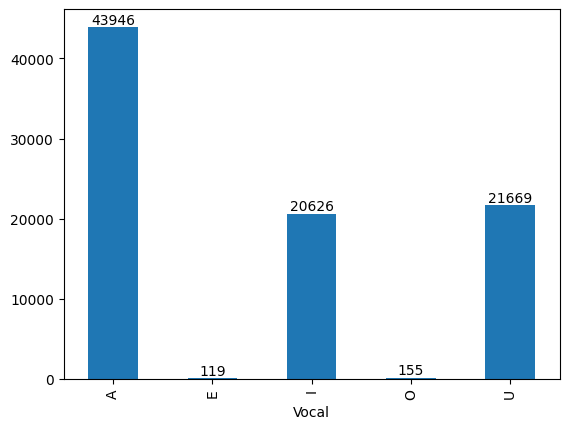

In [37]:
# !pip install matplotlib

import pandas as pd
import matplotlib.pyplot as plt

df_final = pd.DataFrame(list(vocales.items()), columns=['Vocal', 'Total'])
ax = df_final.plot(kind='bar', x='Vocal', y='Total', legend=False)

ax.bar_label(ax.containers[0])

plt.show()

### Conclusiones

* De una lista de 28 mil palabras distintas el uso más extendido es el de la vocal **A**, seguido de la **U** y finalmente la **I**.

* En la variante del quechua estudiado se tiene en cuenta las palabras importadas del español, las cuales pueden contener las vocales **E** y **O**.